In [1]:
import os
import csv
import pandas as pd

# Function to traverse the subfolders and collect image paths
def collect_image_paths(root_folder):
    image_paths = []
    for folder_num, folder_name in enumerate(sorted(os.listdir(root_folder)), start=1):
        folder_path = os.path.join(root_folder, folder_name)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):  # Add more image extensions if needed
                    image_path = os.path.join(folder_path, filename)
                    image_paths.append((image_path, folder_num))
    return image_paths

# Function to write the image paths and labels to a CSV file
def write_to_csv(image_paths, csv_filename):
    with open(csv_filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Image Path', 'Label'])
        for image_path, label in image_paths:
            csv_writer.writerow([image_path, label])

# Main function
def main():
    root_folder = 'D:\SEM - 6\DP\Project\Segmented Medicinal Leaf Images'
    csv_filename = 'image_labels.csv'
    image_paths = collect_image_paths(root_folder)
    write_to_csv(image_paths, csv_filename)
    df = pd.read_csv(csv_filename)
    print(df.head(100))
    print("CSV file created successfully.")

if __name__ == "__main__":
    main()



<>:27: SyntaxWarning: invalid escape sequence '\S'
<>:27: SyntaxWarning: invalid escape sequence '\S'
C:\Users\abhin\AppData\Local\Temp\ipykernel_30592\3463993245.py:27: SyntaxWarning: invalid escape sequence '\S'
  root_folder = 'D:\SEM - 6\DP\Project\Segmented Medicinal Leaf Images'


                                           Image Path  Label
0   D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      1
1   D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      1
2   D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      1
3   D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      1
4   D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      1
..                                                ...    ...
95  D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      2
96  D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      2
97  D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      2
98  D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      2
99  D:\SEM - 6\DP\Project\Segmented Medicinal Leaf...      2

[100 rows x 2 columns]
CSV file created successfully.


In [4]:
# Example usage:
csv_file = r"D:\SEM - 6\DP\Project\image_labels.csv"  # Assuming your CSV file contains two columns: 'image_path' and 'label'


In [5]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file)

# Assuming the CSV has columns named 'img_paths' and 'label'
# Group by 'label' and count the occurrences
label_counts = df.groupby('Label').size()

# Print the count of images for each label
print(label_counts)


Label
1      50
2     122
3      56
4      60
5     103
6      34
7      74
8      57
9      50
10     63
11     43
12     71
13     62
14     97
15     77
16     56
17     60
18     62
19     40
20     52
21     48
22     48
23     61
24     65
25     79
26     58
27     39
28     56
29     56
30     36
dtype: int64


Model


In [8]:
import pandas as pd
# from vit_pytorch import ViT
import torch
from torchvision import datasets, transforms, models
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
from torch.utils.data import random_split


from torch.utils.data import random_split, Dataset, DataLoader
import pandas as pd





In [9]:


# Load CSV file containing image paths and labels
csv_file = r"D:\SEM - 6\DP\Project\image_labels.csv" # Replace with your CSV file path
df = pd.read_csv(csv_file)

# Define transforms to apply to the images
transform = transforms.Compose([
    transforms.Resize((144,144)),  # Resize images to 256x256
    transforms.ToTensor(),           # Convert images to tensors
])



# Function to load images and labels
def load_images_and_labels(csv_file, transform):
    images = []
    labels = []
    for index, row in df.iterrows():
        image_path = row['Image Path']
        label = row['Label']-1
        # Load image
        image = Image.open(image_path).convert('RGB')
        # Apply transforms
        image = transform(image)
        images.append(image)
        labels.append(label)
    return torch.stack(images), torch.tensor(labels)

# Load images and labels
images, labels = load_images_and_labels(csv_file, transform)

# Assuming you have defined your train and validation datasets
# Split the dataset into train and validation sets
dataset = TensorDataset(images, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create dataloaders for train and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)


# Print the shape of the images tensor
print("Image size after transformations:", images.shape[2:])  # Excluding batch size and channels

Image size after transformations: torch.Size([144, 144])


Training

Res-net - 50

In [59]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import numpy as np

# Assuming you have defined train_dataloader and val_dataloader for your data

# Initialize the ResNet50 model
model = models.resnet50(pretrained=True)
# Modify the output layer for 30 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 30)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 50
best_loss = float('inf')  # Initialize with a high value
patience = 5  # Number of epochs to wait for improvement

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_running_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())
    
    val_loss = val_running_loss / len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Print epoch stats
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Train Accuracy: {100 * train_accuracy}%, Val Accuracy: {100 * val_accuracy}%")

    # Early stopping logic based on training loss
    if train_loss < best_loss:
        best_loss = train_loss
        patience = 5  # Reset patience counter
    else:
        patience -= 1
        if patience == 0:
            print(f"Early stopping triggered after {epoch + 1} epochs due to no improvement in training loss")
            break

# Save the trained model
torch.save(model.state_dict(), 'resnet_50_classes.pth')

Epoch 1/50, Train Loss: 3.2097919214648836, Val Loss: 5.149249190869539, Train Accuracy: 10.626702997275205%, Val Accuracy: 7.901907356948229%
Epoch 2/50, Train Loss: 2.435885804225703, Val Loss: 5.394087444181028, Train Accuracy: 25.681198910081743%, Val Accuracy: 7.629427792915531%
Epoch 3/50, Train Loss: 2.0665102787823377, Val Loss: 1.5634493795425997, Train Accuracy: 37.19346049046322%, Val Accuracy: 47.68392370572207%
Epoch 4/50, Train Loss: 1.6752128366391081, Val Loss: 1.7990718349490478, Train Accuracy: 47.88828337874659%, Val Accuracy: 50.40871934604905%
Epoch 5/50, Train Loss: 1.3837490795581153, Val Loss: 1.869266752153635, Train Accuracy: 56.19891008174387%, Val Accuracy: 42.77929155313351%
Epoch 6/50, Train Loss: 1.1144526604085918, Val Loss: 3.777120053768158, Train Accuracy: 64.64577656675749%, Val Accuracy: 22.070844686648503%
Epoch 7/50, Train Loss: 0.91862496509336, Val Loss: 0.8362530207099474, Train Accuracy: 68.93732970027247%, Val Accuracy: 74.38692098092643%
Epo

Save the model

In [87]:
import pickle

# Load the saved model using pickle
with open('resnet_50_classes.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


Evaluation Metrics


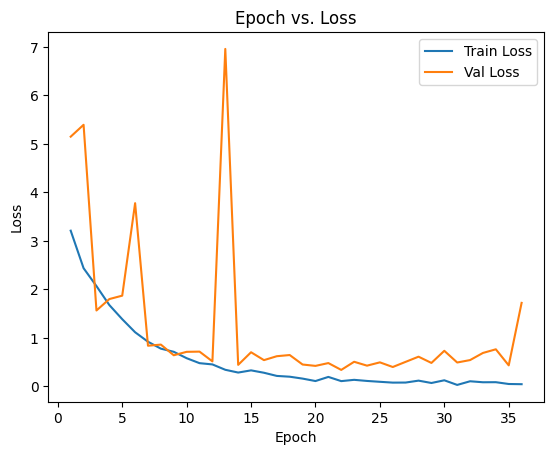

In [64]:
# Plot epoch vs. loss
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs. Loss')
plt.legend()
plt.show()

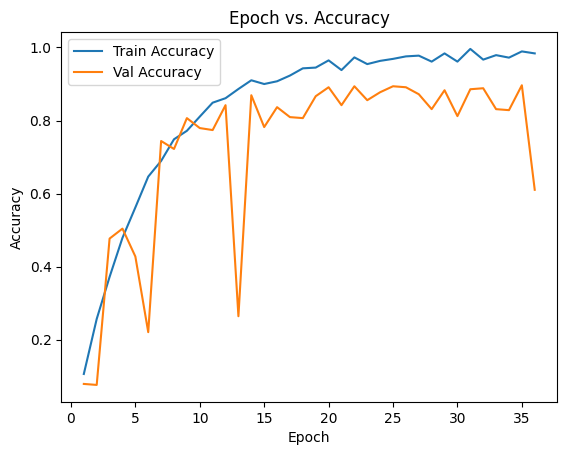

In [65]:
# Plot epoch vs. accuracy
plt.figure()
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs. Accuracy')
plt.legend()
plt.show()

In [81]:
import torch

def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total if total > 0 else 0
    return accuracy

def calculate_recall(model, dataloader, num_classes):
    model.eval()
    class_correct = torch.zeros(num_classes)
    class_total = torch.zeros(num_classes)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = predicted == labels
            for i in range(num_classes):
                class_correct[i] += (correct * (labels == i)).sum().item()
                class_total[i] += (labels == i).sum().item()

    recall_per_class = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    overall_recall = class_correct.sum() / class_total.sum() if class_total.sum() > 0 else 0
    return recall_per_class, overall_recall
from sklearn.metrics import precision_score, f1_score

def calculate_precision(model, dataloader):
    model.eval()
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    predicted_labels = np.argmax(all_outputs, axis=1)
    
    precision = precision_score(all_labels, predicted_labels, average='weighted')
    return precision

def calculate_f1_score(model, dataloader):
    model.eval()
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    predicted_labels = np.argmax(all_outputs, axis=1)
    
    f1 = f1_score(all_labels, predicted_labels, average='weighted')
    return f1

# Calculate precision for validation data
val_precision = calculate_precision(model, val_dataloader)
print(f"Validation Precision: {val_precision:.4f}")

# Calculate F1-score for validation data
val_f1_score = calculate_f1_score(model, val_dataloader)
print(f"Validation F1 Score: {val_f1_score:.4f}")

# Calculate accuracy for validation data
val_accuracy = calculate_accuracy(model, val_dataloader)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Calculate recall for validation data
val_recall_per_class, val_overall_recall = calculate_recall(model, val_dataloader, num_classes=30)
print(f"Validation Recall per Class: {val_recall_per_class}")
print(f"Validation Overall Recall: {val_overall_recall:.4f}")


c:\Users\abhin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Precision: 0.7752
Validation F1 Score: 0.6100
Validation Accuracy: 0.6104
Validation Recall per Class: [tensor(1.), tensor(0.4375), tensor(0.8667), tensor(0.7857), tensor(0.7368), tensor(1.), tensor(0.8333), tensor(0.4211), tensor(1.), tensor(0.5833), tensor(0.1250), tensor(0.3077), tensor(0.2727), tensor(0.7778), tensor(0.4667), tensor(0.7857), tensor(0.2381), tensor(0.2500), tensor(0.6667), tensor(0.7500), tensor(0.9000), tensor(1.), tensor(1.), tensor(1.), tensor(0.7143), tensor(0.4000), tensor(0.), tensor(0.8333), tensor(0.4667), tensor(0.)]
Validation Overall Recall: 0.6104


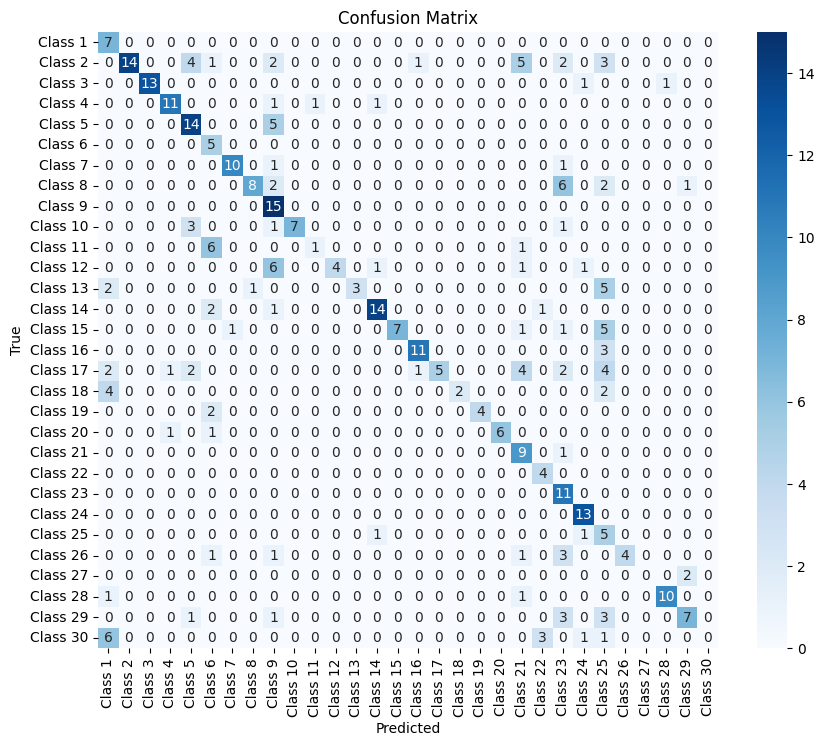

In [69]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


def collect_predictions_and_labels(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    return np.array(all_labels), np.array(all_predictions)

# Collect predictions and true labels for the validation set
true_labels, predictions = collect_predictions_and_labels(model, val_dataloader)
cm = confusion_matrix(true_labels, predictions, labels=np.arange(30))

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Define your class names
class_names = [f'Class {i+1}' for i in range(30)]

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names)


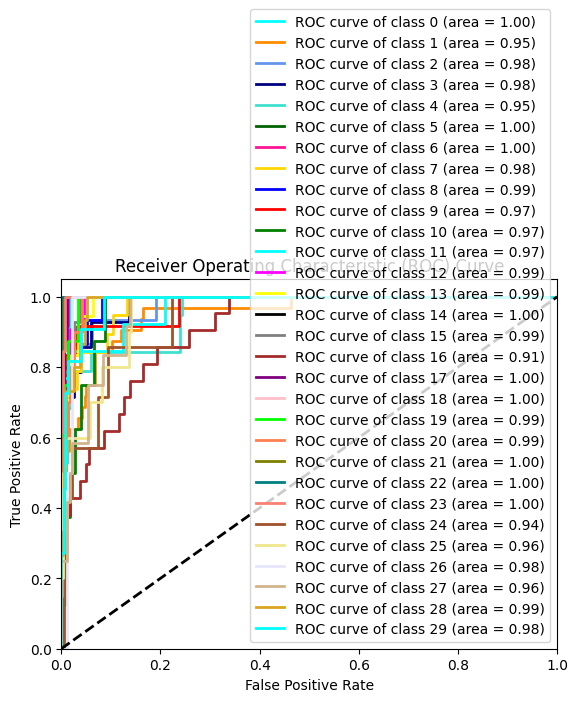

In [67]:
 # Calculate ROC curve and ROC area for each class
all_labels = np.concatenate(all_labels)
all_outputs = np.concatenate(all_outputs)
n_classes = 30
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_outputs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'turquoise', 'darkgreen', 'deeppink', 'gold', 'blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'grey', 'brown', 'purple', 'pink', 'lime', 'coral', 'olive', 'teal', 'salmon', 'sienna', 'khaki', 'lavender', 'tan', 'goldenrod'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
 






